In [1]:
import pickle
import pandas as pd 
import numpy as np
import torch
import os
from math import ceil
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem.rdForceFieldHelpers import UFFOptimizeMolecule
from openbabel import pybel
import re

In [2]:
import py3Dmol
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, Image
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 600, 300

In [3]:
import sys
sys.path.append('..')

In [4]:
from utils_eval import build_pdb_dict, pp_match, extract_pp, extract_all_pp, group_by
from pp_matching_specific_site import compute_center
from data_processing.ligand import Ligand

In [98]:
# ligand_name = '1ywn_A_rec_1ywn_lif_lig_tt_docked_0'  # 0 0
# ligand_name = '4b81_B_rec_4ara_c56_lig_tt_min_0'  # 0.41 0.51
# ligand_name = '1lhu_A_rec_1lhn_aon_lig_tt_min_0'  # 0.07 0.11
# ligand_name = '4b84_A_rec_4b84_z5k_lig_tt_min_0'  # 0.60 0.61
# ligand_name = '3fu5_A_rec_5ni6_dj3_lig_tt_min_0'  
# ligand_name = '5hbh_A_rec_5idn_6a7_lig_tt_min_0'
# ligand_name = '5aen_A_rec_5ni2_dj3_lig_tt_min_0'
# ligand_name = '3d3e_B_rec_4ijw_1eq_lig_tt_min_0'
# ligand_name = '4yyz_B_rec_3ey4_352_lig_tt_docked_12'
# ligand_name = '4h7c_A_rec_3r58_nps_lig_tt_min_0'  # 0.64 0.70
# ligand_name = '3ey4_C_rec_4k1l_sff_lig_tt_min_0'  # 0.59 0.59 

# ligand_name = '3hfg_A_rec_3hfg_17r_lig_tt_min_0'
# ligand_name = '3ey4_C_rec_5pgu_8k4_lig_tt_min_0'  # 0.11 0.10
# ligand_name = '5ni2_A_rec_5aen_dp8_lig_tt_min_0'
# ligand_name = '3fu5_A_rec_5ni6_dj3_lig_tt_min_0'
# ligand_name = '4yyz_B_rec_2ilt_nn1_lig_tt_min_0'  # 0.16 0.20 
# ligand_name = '4bnn_A_rec_4bnm_tcu_lig_tt_min_0'
# ligand_name = '4yvx_A_rec_1s2a_imn_lig_tt_min_0'
# ligand_name = '3czr_B_rec_4bb5_hd2_lig_tt_min_0'
# ligand_name = '3czr_A_rec_2ilt_nn1_lig_tt_min_0'
# ligand_name = '4b84_A_rec_4btl_5gz_lig_tt_min_0'
# ligand_name = '3fue_A_rec_3ftv_11x_lig_tt_min_0'  # 0.04 0.05
# ligand_name = '4bnk_B_rec_4d44_ja3_lig_tt_min_0'  # 0.26 0.27
# ligand_name = '3qqp_B_rec_4k1l_sff_lig_tt_min_0'
# ligand_name = '4wdu_A_rec_3r94_flr_lig_tt_min_0'  # 0.37 0.27
# ligand_name = '4alj_A_rec_4bnf_pv4_lig_tt_docked_0'  # 0.24 0.24
# ligand_name = '1ejj_A_rec_1o99_2pg_lig_tt_docked_0'
# ligand_name = '4h96_B_rec_4h95_06u_lig_tt_min_0'  # 0.40 0.42
# ligand_name = '2oa6_D_rec_4kvi_1sv_lig_tt_min_0'  # 0.36 0.41
# ligand_name = '4hx5_B_rec_3bzu_a21_lig_tt_min_0'
# ligand_name = '5pgy_D_rec_3bzu_a21_lig_tt_min_0'
# ligand_name = '5pgv_A_rec_3bzu_a21_lig_tt_min_0'
# ligand_name = '4kux_B_rec_4kvw_jf4_lig_tt_min_0'  # 0.61 0.63
# ligand_name = '4bnk_B_rec_4bnl_w1g_lig_tt_min_0'
# ligand_name = '4b82_B_rec_4ara_c56_lig_tt_min_0'  # 0.42 0.53
# ligand_name = '4pm0_A_rec_4y2b_epk_lig_tt_min_0'
# ligand_name = '4ms6_A_rec_3fuh_5h1_lig_tt_min_0'  # 0.02 0.02
# ligand_name = '5ivg_B_rec_4kvy_jf1_lig_tt_docked_9'  # 0.61 0.69
# ligand_name = '3r8h_A_rec_3r8h_zom_lig_tt_min_0'
# ligand_name = '1aoe_A_rec_3qlr_qlr_lig_tt_docked_4'  # 0.19 0.28
# ligand_name = '2ilt_A_rec_3ey4_352_lig_tt_min_0'  # 0.70 0.71
# ligand_name = '2g1q_A_rec_1x88_nat_lig_tt_min_0'  # 0.59 0.59
# ligand_name = '5imp_B_rec_4kwd_jf2_lig_tt_min_0'  # 0.54 0.55
# ligand_name = '4d45_A_rec_4ali_tcl_lig_tt_min_0'  # 0.57 0.52
# ligand_name = '5ivg_B_rec_4kvw_jf4_lig_tt_min_0'
# ligand_name = '2rbe_C_rec_3byz_h11_lig_tt_min_0'
# ligand_name = '2whr_A_rec_3zlv_hi6_lig_tt_min_0'
# ligand_name = '4hmn_A_rec_3ufy_npx_lig_tt_min_0'
# ligand_name = '4h7c_A_rec_3r6i_jms_lig_tt_min_0'
# ligand_name = '1pha_A_rec_1phg_myt_lig_tt_min_0'
# ligand_name = '1phd_A_rec_1phg_myt_lig_tt_min_0'
# ligand_name = '1phg_A_rec_1phe_piy_lig_tt_min_0'
# ligand_name = '1phg_A_rec_1phg_myt_lig_tt_min_0'
# ligand_name = '1p2y_A_rec_1phg_myt_lig_tt_min_0'
# ligand_name = '1p2y_A_rec_1phe_piy_lig_tt_min_0'
# ligand_name = '5lgq_D_rec_4ikp_4ik_lig_tt_docked_1'
# ligand_name = '1c8j_A_rec_1p2y_nct_lig_tt_min_0'
# ligand_name = '1l5l_A_rec_1l4l_xyd_lig_tt_min_0'
# ligand_name = '4l0s_A_rec_5al5_jl9_lig_tt_min_0'  # not done nicely
# ligand_name = '2pg2_A_rec_2wog_zzd_lig_tt_min_0'
# ligand_name = '4yur_A_rec_3cok_anp_lig_tt_min_0'
# ligand_name = '3ny8_A_rec_4ldo_ale_lig_tt_docked_4'
# ligand_name = '5bzf_A_rec_4np2_2l1_lig_tt_min_0'
# ligand_name = '5bze_A_rec_5bzg_4x6_lig_tt_min_0'
# ligand_name = '5bzg_A_rec_5bzg_4x6_lig_tt_min_0'
# ligand_name = '4mrg_A_rec_5bzf_4x3_lig_tt_docked_2'
# ligand_name = '4mrg_A_rec_5bzg_4x6_lig_tt_min_0'
# ligand_name = '1k4h_A_rec_1p0b_pq0_lig_tt_docked_0'

# ligand_name = '4xud_A_rec_5lsa_dnc_lig_tt_docked_2'  # good
# ligand_name = '4xue_B_rec_5lsa_dnc_lig_tt_docked_10' # good
# ligand_name = '4xuc_A_rec_5lsa_dnc_lig_tt_min_0'  # good
# ligand_name = '4xuc_A_rec_5lsa_dnc_lig_tt_docked_7'

# ligand_name = '1eoc_A_rec_2buz_4nc_lig_tt_docked_4'  # okay
# ligand_name = '2bur_A_rec_1eoc_4nc_lig_tt_min_0'  # okay
# ligand_name = '1eob_A_rec_2buz_4nc_lig_tt_min_0'  # okay
# ligand_name = '1eoc_A_rec_1eoc_4nc_lig_tt_min_0'  # okay
# ligand_name = '2buq_A_rec_2buz_4nc_lig_tt_min_0'  # okay
# ligand_name = '1eoc_A_rec_2buz_4nc_lig_tt_min_0'  # okay
# ligand_name = '2bur_A_rec_2buz_4nc_lig_tt_min_0'  # okay
# ligand_name = '1eob_A_rec_2buu_4nc_lig_tt_min_0'  # not so good
# ligand_name = '2buu_A_rec_1eoc_4nc_lig_tt_min_0'  # okay

# ligand_name = '5ehq_A_rec_1j06_ae3_lig_tt_min_0'

# ligand_name = '3occ_C_rec_3occ_dih_lig_tt_min_0'  # No 5 is alright
# ligand_name = '1oty_A_rec_3occ_dih_lig_tt_docked_18'  # No 3, 17 are alright

ligand_name = '5uez_A_rec_5uev_88y_lig_tt_min_0'  # 68, 90

# ligand_name = '5lvr_A_rec_5fe6_5wz_lig_tt_min_0'  # No 2, 4 have better 5 node rings 

# ligand_name = '5nu3_A_rec_5lpj_xdm_lig_tt_docked_5'

# ligand_name = '4np3_A_rec_5bze_68n_lig_tt_min_0'

# ligand_name = '2xr9_A_rec_5ijs_5jk_lig_tt_min_0'

# ligand_name = '2xud_A_rec_4a23_c56_lig_tt_min_0'

# ligand_name = '5mhp_A_rec_3waw_dww_lig_tt_docked_17'

# ligand_name = '1e3k_A_rec_1a28_str_lig_tt_docked_2'

# ligand_name = '3h3q_A_rec_3h3q_h13_lig_tt_docked_1'

# ligand_name = '5l0b_A_rec_5l0b_6zm_lig_it1_tt_docked_1'

# ligand_name = '4b85_B_rec_4ara_c56_lig_tt_docked_2'

# ligand_name = '1otx_A_rec_4tti_fmc_lig_tt_min_0'  # No 3, 4 is alright

# ligand_name = '2evs_A_rec_4h2z_mys_lig_tt_min_0'

In [99]:
# ligand_name = 'test4'

In [100]:
bridge_type = 'vp'
root_path = os.path.join('structure_based', bridge_type, ligand_name)
# root_path = os.path.join('ligand_based', ligand_name)
aromatic = True
gen_path = os.path.join(root_path, 'aromatic' if aromatic else 'basic')

optimization = False
gen_path += '_optimized' if optimization else ''

In [101]:
score_file = os.path.join(root_path, 'aromatic_matches.pkl' if aromatic else 'basic_matches.pkl')
with open(score_file, 'rb') as f:
    matches = pickle.load(f)
matches

{'5uev_54': array([1, 1, 1, 1]),
 '5uev_90': array([1, 1, 0, 1]),
 '5uev_73': array([1, 1, 0, 1]),
 '5uev_71': array([1, 1, 0, 1]),
 '5uev_97': array([1, 1, 0, 1]),
 '5uev_0': array([1, 1, 0, 1]),
 '5uev_9': array([1, 1, 0, 1]),
 '5uev_19': array([1, 1, 1, 1]),
 '5uev_51': array([1, 1, 0, 1]),
 '5uev_58': array([1, 1, 0, 1]),
 '5uev_98': array([1, 1, 0, 1]),
 '5uev_56': array([1, 1, 0, 1]),
 '5uev_18': array([1, 1, 0, 1]),
 '5uev_3': array([1, 1, 0, 1]),
 '5uev_65': array([1, 1, 0, 1]),
 '5uev_64': array([1, 1, 1, 1]),
 '5uev_68': array([1, 1, 0, 1]),
 '5uev_17': array([1, 1, 0, 1]),
 '5uev_82': array([1, 1, 0, 1]),
 '5uev_53': array([1, 1, 0, 1]),
 '5uev_20': array([1, 1, 0, 1]),
 '5uev_36': array([1, 1, 1, 1]),
 '5uev_96': array([1, 1, 1, 1]),
 '5uev_6': array([1, 1, 0, 1]),
 '5uev_35': array([1, 1, 0, 1]),
 '5uev_57': array([1, 1, 0, 1]),
 '5uev_49': array([1, 1, 0, 1]),
 '5uev_83': array([1, 1, 0, 1]),
 '5uev_70': array([1, 1, 0, 1]),
 '5uev_77': array([1, 1, 0, 1]),
 '5uev_91': ar

In [102]:
test_data = torch.load(os.path.join('structure_based', ligand_name, ligand_name + '_aromatic' + '.pt' if aromatic else ligand_name + '.pt'))
center = compute_center(test_data['target_pos'], test_data['Gt_mask'])

with open(os.path.join('structure_based', ligand_name, 'pp_info.pkl'), 'rb') as f:
    pp_info = pickle.load(f)

pp_info['pp_positions'] = pp_info['pp_positions'] - center
pp_info['pp_positions']

tensor([[ 0.9589,  3.2299, -1.1211],
        [-2.4715,  1.1072, -3.2700],
        [ 2.5406, -0.8810,  1.3425],
        [-0.4421,  2.1493, -3.8931]])

In [103]:
pp_info['pp_types']

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [104]:
raw_data_path = '../../data/cleaned_crossdocked_data/raw'
pdb_dict, pdb_rev_dict = build_pdb_dict(raw_data_path)

In [105]:
def test_ref_ligand(gen_lig, ori_lig, path=gen_path, raw_path=raw_data_path, pdb_rev_dict=pdb_rev_dict):
    # example = os.path.join(path, gen_lig+'.sdf')
    m = Chem.MolFromMolFile(gen_lig)
    # m = Chem.AddHs(m)

    pdb_folder = pdb_rev_dict[ori_lig+'.sdf']
    ref_file = os.path.join(raw_path, pdb_folder, ori_lig+'.sdf')
    ref_m = Chem.MolFromMolFile(ref_file)
    return m, ref_m

In [106]:
lig_id = ligand_name[ligand_name.rfind('rec')+4:ligand_name.rfind('rec')+8]

In [108]:
for i in range(100):
    lig_file = os.path.join(gen_path, lig_id + '_' + str(i) + '.sdf')
    pbmol = next(pybel.readfile("sdf", lig_file))
    num_ring = len(pbmol.sssr)
    if num_ring >= 1:
        rings = pbmol.OBMol.GetSSSR()
        for ring in rings:
            # print(ring.Size())
            if ring.Size() == 6:
                # print(ring.IsAromatic())
                print(i)
                # print(len(ring))

1
2
3
4
5
6
7
8
8
9
11
11
15
16
17
19
20
21
25
26
27
28
30
30
31
32
33
34
35
36
38
39
40
41
42
43
44
46
47
48
49
50
51
53
54
55
56
57
58
61
62
63
64
65
66
67
68
69
70
71
72
73
76
77
79
81
82
83
84
85
86
90
91
92
93
94
95
96
97
99


In [280]:
idx = '8'
lig_file = os.path.join(gen_path, lig_id + '_' + idx + '.sdf')
lig_file

'structure_based/vp/5uez_A_rec_5uev_88y_lig_tt_min_0/aromatic/5uev_8.sdf'

In [281]:
rec_mol_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-08-19_21_05_04.140916/ligand_based/reconstructed_mols_aromatic_mode'
lig_file2 = os.path.join(rec_mol_path, ligand_name+'.sdf')

In [282]:
matches[lig_id + '_' + idx]

array([1, 1, 1, 1])

In [283]:
rdmol = Chem.MolFromMolFile(lig_file, sanitize=True)
pbmol = next(pybel.readfile("sdf", lig_file))
try:
    # rdmol = Chem.AddHs(rdmol)
    ligand = Ligand(pbmol, rdmol, atom_positions=None, conformer_axis=None, filtering=False, preprocess=False)
except:
    print('ligand init failed')
pp_atom_indices, pp_positions, pp_types, pp_index = extract_all_pp(ligand) # extract_pp(ligand) 
print(pp_types)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, [5, 6], [5, 6]]


In [284]:
num_ring = len(pbmol.sssr)
if num_ring >= 1:
    for ring in pbmol.sssr:
        print(ring.IsAromatic())

False
False


In [285]:
for node in ligand.graph.nodes:
    print(node.positions.squeeze())
    print(node.types, node.index)
    atom_indices = list([node.atom_indices]) if type(node.atom_indices)==int else list(sorted(node.atom_indices))
    print(atom_indices)

[-0.9563 -1.4057  1.6735]
['Hydrophobic'] 0
[0]
[-0.0215 -2.7816  3.2694]
['Hydrophobic'] 1
[1]
[-0.9319 -2.3788  2.7913]
['Hydrophobic'] 2
[2]
[ 0.935  -2.2754  2.7926]
['Hydrophobic'] 3
[4]
[-0.0357 -1.4765  1.2846]
['Hydrophobic'] 4
[5]
[ 0.2067  1.5895 -1.7135]
['Hydrophobic'] 5
[8]
[ 1.3268  1.7386 -0.2764]
['Hydrophobic'] 6
[9]
[-0.1812  0.6407 -1.0509]
['Hydrophobic'] 7
[10]
[ 0.9299  2.575  -1.2636]
['Hydrophobic'] 8
[11]
[-0.1946  0.2851 -0.4785]
['Hydrophobic'] 9
[12]
[-2.0602  0.5097 -2.7323]
['Hydrophobic'] 10
[13]
[ 1.4411 -0.3961  0.658 ]
['HBond_donor', 'HBond_acceptor'] 11
[6]
[-0.2974  1.9346 -3.2523]
['HBond_donor', 'HBond_acceptor'] 12
[15]


In [286]:
# rdmol2 = Chem.MolFromMolFile(lig_file2, sanitize=True)
# pbmol2 = next(pybel.readfile("sdf", lig_file2))
# try:
#     # rdmol = Chem.AddHs(rdmol)
#     ligand2 = Ligand(pbmol2, rdmol2, atom_positions=None, conformer_axis=None, filtering=False, preprocess=False)
# except:
#     print('ligand init failed')

In [287]:
# for node in ligand2.graph.nodes:
#     print(node.positions.squeeze())
#     print(node.types, node.index)
#     atom_indices = list([node.atom_indices]) if type(node.atom_indices)==int else list(sorted(node.atom_indices))
#     print(atom_indices)

In [288]:
# mol_, highlights = group_by(rdmol2, ligand2)
# imgsize = (600, 500)
# drawer = rdMolDraw2D.MolDraw2DSVG(*imgsize)
# drawer.DrawMolecule(mol_, **highlights)
# drawer.FinishDrawing()
# svg = drawer.GetDrawingText()
# display(SVG(svg.replace('svg:','')))

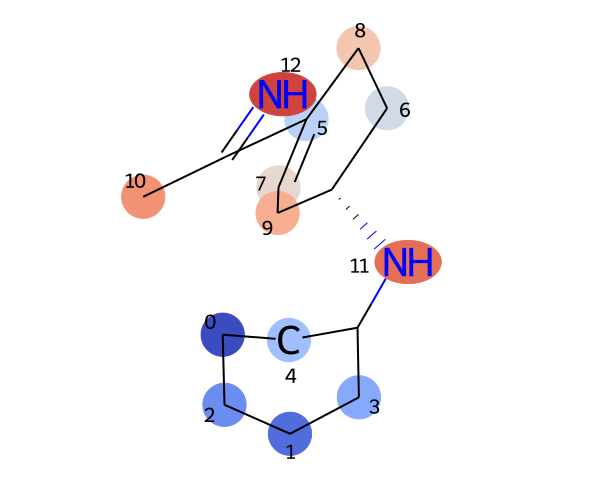

In [289]:
mol_, highlights = group_by(rdmol, ligand)
imgsize = (600, 500)
drawer = rdMolDraw2D.MolDraw2DSVG(*imgsize)
drawer.DrawMolecule(mol_, **highlights)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()
display(SVG(svg.replace('svg:','')))

In [290]:
# Chem.MolFromSmiles(Chem.MolToSmiles(rdmol2))

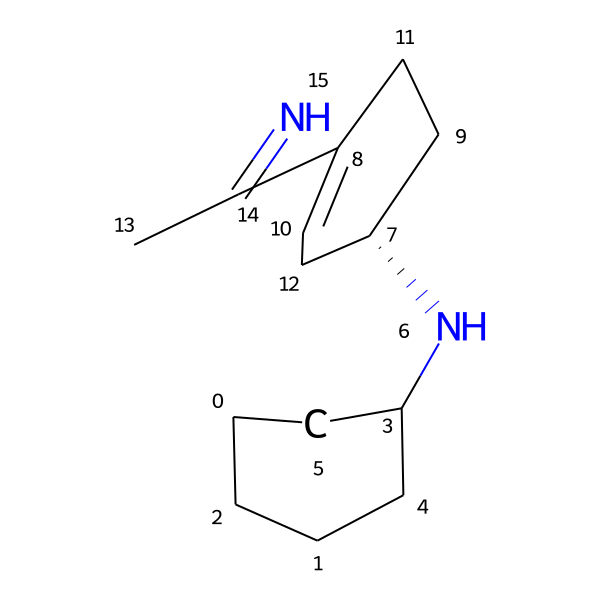

In [291]:
m, ref_m = test_ref_ligand(lig_file, ligand_name)
m

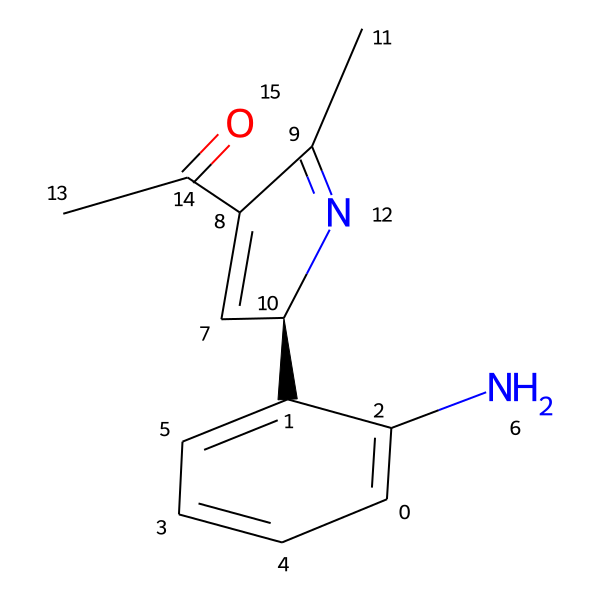

In [292]:
ref_m

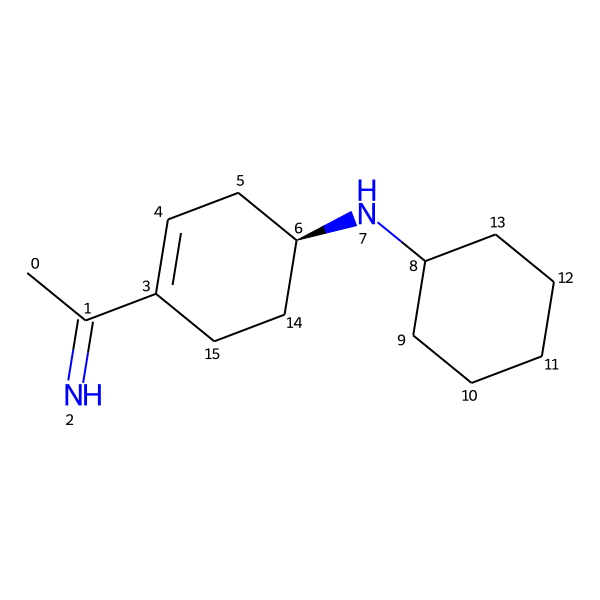

In [293]:
m_2d = Chem.MolFromSmiles(Chem.MolToSmiles(m))
m_2d

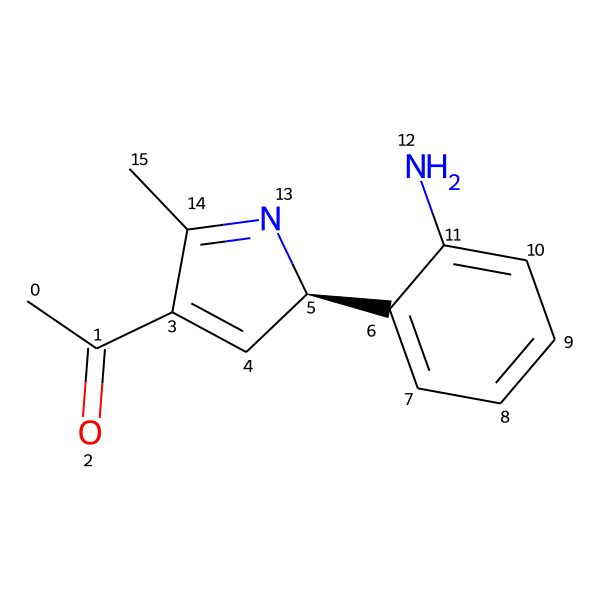

In [294]:
ref_m_2d = Chem.MolFromSmiles(Chem.MolToSmiles(ref_m))
ref_m_2d

In [295]:
def compare(gen_lig, ori_lig, gen_path=gen_path, raw_data_path=raw_data_path, pdb_rev_dict=pdb_rev_dict):
    # example = os.path.join(path, ligand+'.sdf')

    pattern = r"(\w+_[A-Z]_rec)"
    match = re.search(pattern, ori_lig)
    pdb_folder = pdb_rev_dict[ori_lig+'.sdf']
    pr_pdb = match.group(1)
    print(pr_pdb)
    # protein_file = os.path.join(raw_data_path, pdb_folder, pr_pdb + '.pdb')

    ligand_fn = ori_lig[ori_lig.rfind('rec')+4:ori_lig.rfind('lig')+3]
    # autobox_ligand_file = os.path.join(raw_data_path, pdb_folder, ligand_fn + '.pdb')
    autobox_ligand_file = os.path.join('structure_based', ori_lig, ori_lig+'.sdf')

    ligand_file = gen_lig # os.path.join(gen_path, gen_lig+'.sdf')

    # out_folder = 'output_aromatic' if aromatic else 'output'
    # out_file = os.path.join(root_path, out_folder, gen_lig)
    # out_file = os.path.join('../../', ligand + '.sdf')
    
    v = py3Dmol.view()
    # v.addModel(open(protein_file).read())
    # v.setStyle({'cartoon':{},'stick':{'radius':.1}})
    v.addModel(open(autobox_ligand_file).read())
    v.setStyle({'model':0},{'stick':{'colorscheme':'dimgrayCarbon','radius':.125}})
    v.addModels(open(ligand_file).read())
    v.setStyle({'model':1},{'stick':{'colorscheme':'greenCarbon','radius':.125}})
    # v.zoomTo({'model':1})
    v.rotate(90)
    # v.animate({'interval':1000})
    
    return v

In [296]:
compare(lig_file, ligand_name)

5uez_A_rec


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [297]:
def compare_test(gen_lig, ori_lig, gen_path=gen_path):
    gen_lig_file = os.path.join(gen_path, gen_lig+'.sdf')
    ori_lig_file = os.path.join(gen_path, '..', ori_lig+'.sdf')
    
    v = py3Dmol.view()
    # v.addModel(open(protein_file).read())
    # v.setStyle({'cartoon':{},'stick':{'radius':.1}})
    v.addModel(open(ori_lig_file).read())
    v.setStyle({'model':0},{'stick':{'colorscheme':'dimgrayCarbon','radius':.125}})
    v.addModels(open(gen_lig_file).read())
    v.setStyle({'model':1},{'stick':{'colorscheme':'greenCarbon','radius':.125}})
    # v.zoomTo({'model':1})
    # v.rotate(90)

    return v

In [356]:
# gen_lig = 't4_359'
# compare_test(gen_lig, ligand_name)